We will use baysian, IterSVD, Matrix Factorization, Soft impute 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
import numpy as np

from sklearn.model_selection import train_test_split
from statsmodels.imputation import mice
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score)

In [6]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [7]:
missing_data = dataset.isna().sum().sort_values()
missing_data

RID                            0
Gender                         0
Ageatscreening                 0
Diagnosis                      0
HipsSumAveragebaseline         1
MMSE0m                         3
ERCsASMbaseline                4
HipsSumVariancebaseline        7
HipsVariancebaseline           8
ERCsEntropybaseline            9
ERCsSumAveragebaseline        11
ERCsSumVariancebaseline       13
ERCsVariancebaseline          14
HipsContrastbaseline          14
ERCsVolumebaseline            14
ERCsContrastbaseline          18
HipsClusterShadebaseline      18
HipposcampusVolumebaseline    19
HipsCorelationbaseline        20
HipsEntropybaseline           23
HipsASMbaseline               25
ERCsCorelationbaseline        28
ERCsClusterShadebaseline      34
ERCs_thicknessbaseline        37
dtype: int64

In [8]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [9]:
def ppm_imputation(num_iter, X_train, X_test):
    # Define the number of imputations
    n_imputations = num_iter 

    # Store the imputations
    imputed_datasets = []

    # Loop for imputations
    for i in range(n_imputations):
        mice_data = mice.MICEData(X_train, 
                                perturbation_method='gaussian', 
                                k_pmm=20, 
                                history_callback=None)
        mice_data.update_all()
        imputed_datasets.append(mice_data.data)

    # Average the imputed datasets
    X_train_imputed = np.mean(imputed_datasets, axis=0)

    # Repeat for the test dataset
    imputed_datasets_test = []
    for i in range(n_imputations):
        mice_data_test = mice.MICEData(X_test, 
                                    perturbation_method='gaussian', 
                                    k_pmm=20, 
                                    history_callback=None)
        mice_data_test.update_all()
        imputed_datasets_test.append(mice_data_test.data)

    X_test_imputed = np.mean(imputed_datasets_test, axis=0)
    
    return X_train_imputed, X_test_imputed

In [10]:
X_train_imputed_5, X_test_imputed_5 = ppm_imputation(5, X_train, X_test)
X_train_imputed_10, X_test_imputed_10 = ppm_imputation(10, X_train, X_test)
X_train_imputed_15, X_test_imputed_15 = ppm_imputation(15, X_train, X_test)
X_train_imputed_50, X_test_imputed_50 = ppm_imputation(50, X_train, X_test)

In [17]:
dataframes = [
    X_train_imputed_5, X_test_imputed_5, 
    X_train_imputed_10, X_test_imputed_10,
    X_train_imputed_15, X_test_imputed_15,
    X_train_imputed_50, X_test_imputed_50,
]

for df in dataframes:
    if df.isna().any().all() == False:
        print("No missing values in any dataframe")
        break
    else:
        print("Still missing values")

No missing values in any dataframe


In [18]:
X_train_imputed_5 = pd.DataFrame(X_train_imputed_5, columns=X_train.columns)
X_test_imputed_5 = pd.DataFrame(X_test_imputed_5, columns=X_test.columns)

X_train_imputed_10 = pd.DataFrame(X_train_imputed_10, columns=X_train.columns)
X_test_imputed_10 = pd.DataFrame(X_test_imputed_10, columns=X_test.columns)

X_train_imputed_15 = pd.DataFrame(X_train_imputed_15, columns=X_train.columns)
X_test_imputed_15 = pd.DataFrame(X_test_imputed_15, columns=X_test.columns)

X_train_imputed_50 = pd.DataFrame(X_train_imputed_50, columns=X_train.columns)
X_test_imputed_50 = pd.DataFrame(X_test_imputed_50, columns=X_test.columns)

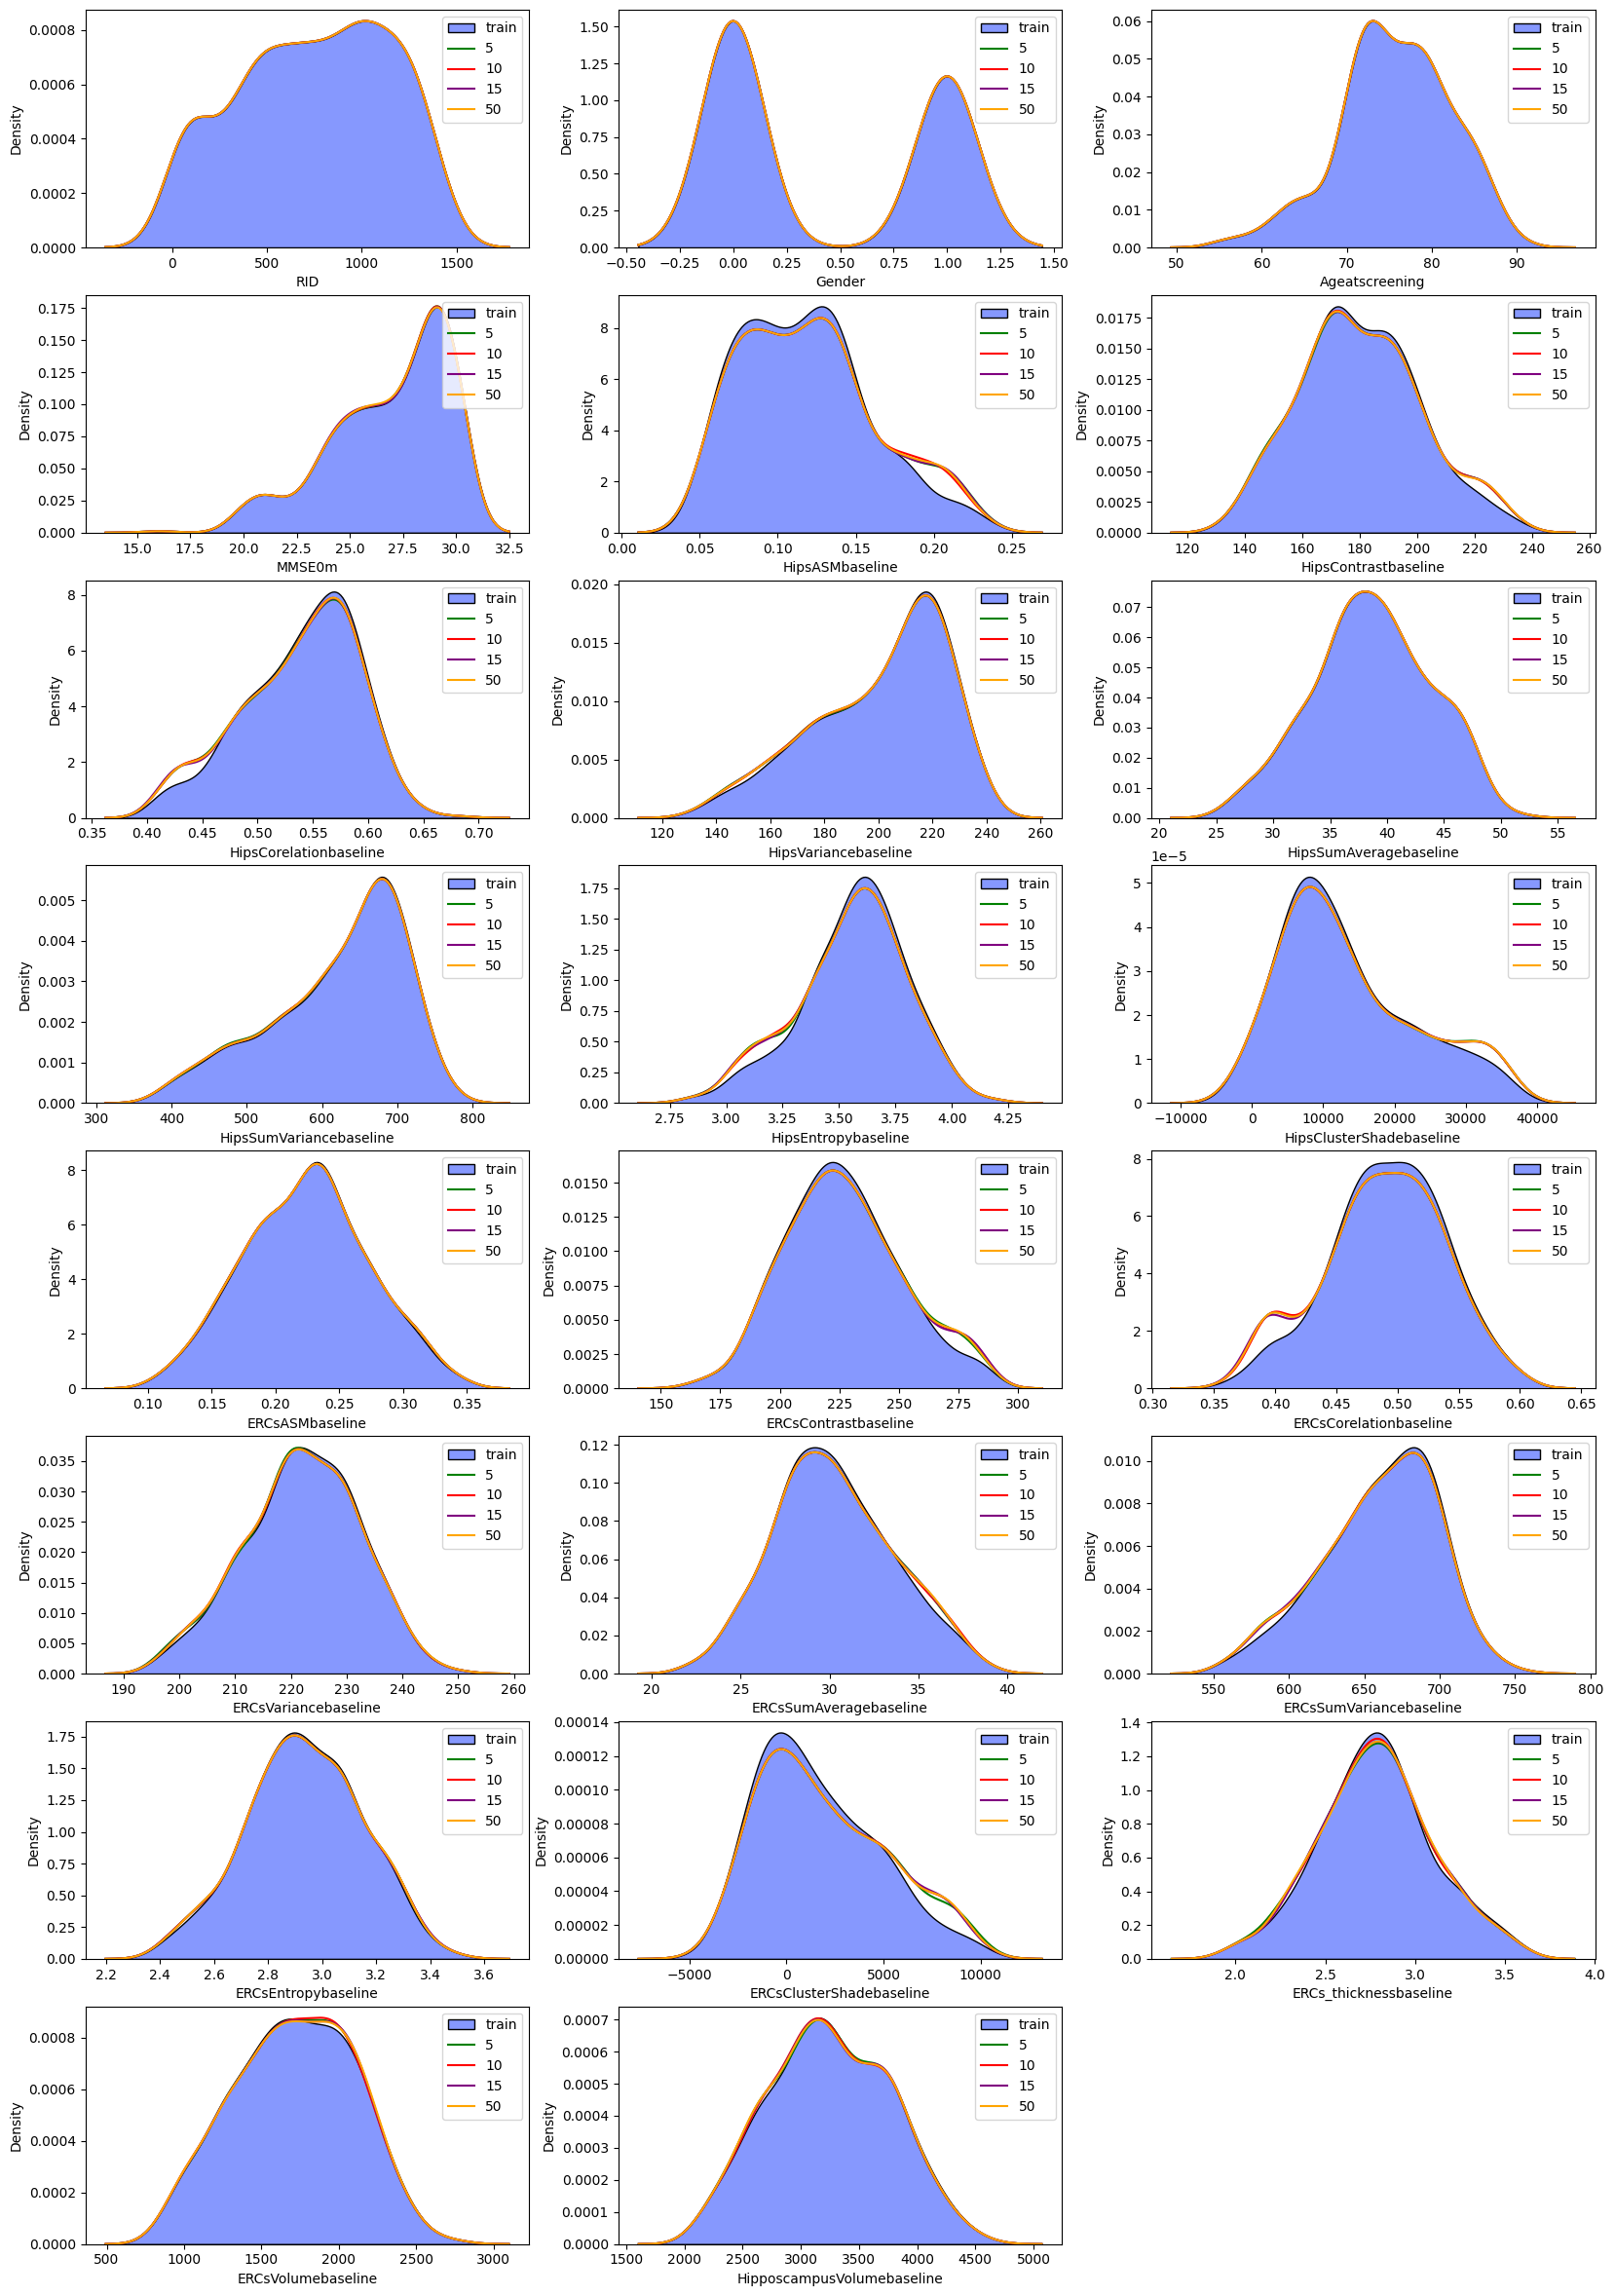

In [20]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_copy[X_train_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_imputed_5[X_train_imputed_5.columns[i]], color= "green")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_imputed_10[X_train_imputed_10.columns[i]], color= "red")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_imputed_15[X_train_imputed_15.columns[i]], color= "purple")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_imputed_50[X_train_imputed_50.columns[i]], color= "orange")
    
    labels = ['train', '5', '10', '15', '50']
    plt.legend(labels, loc='upper right')

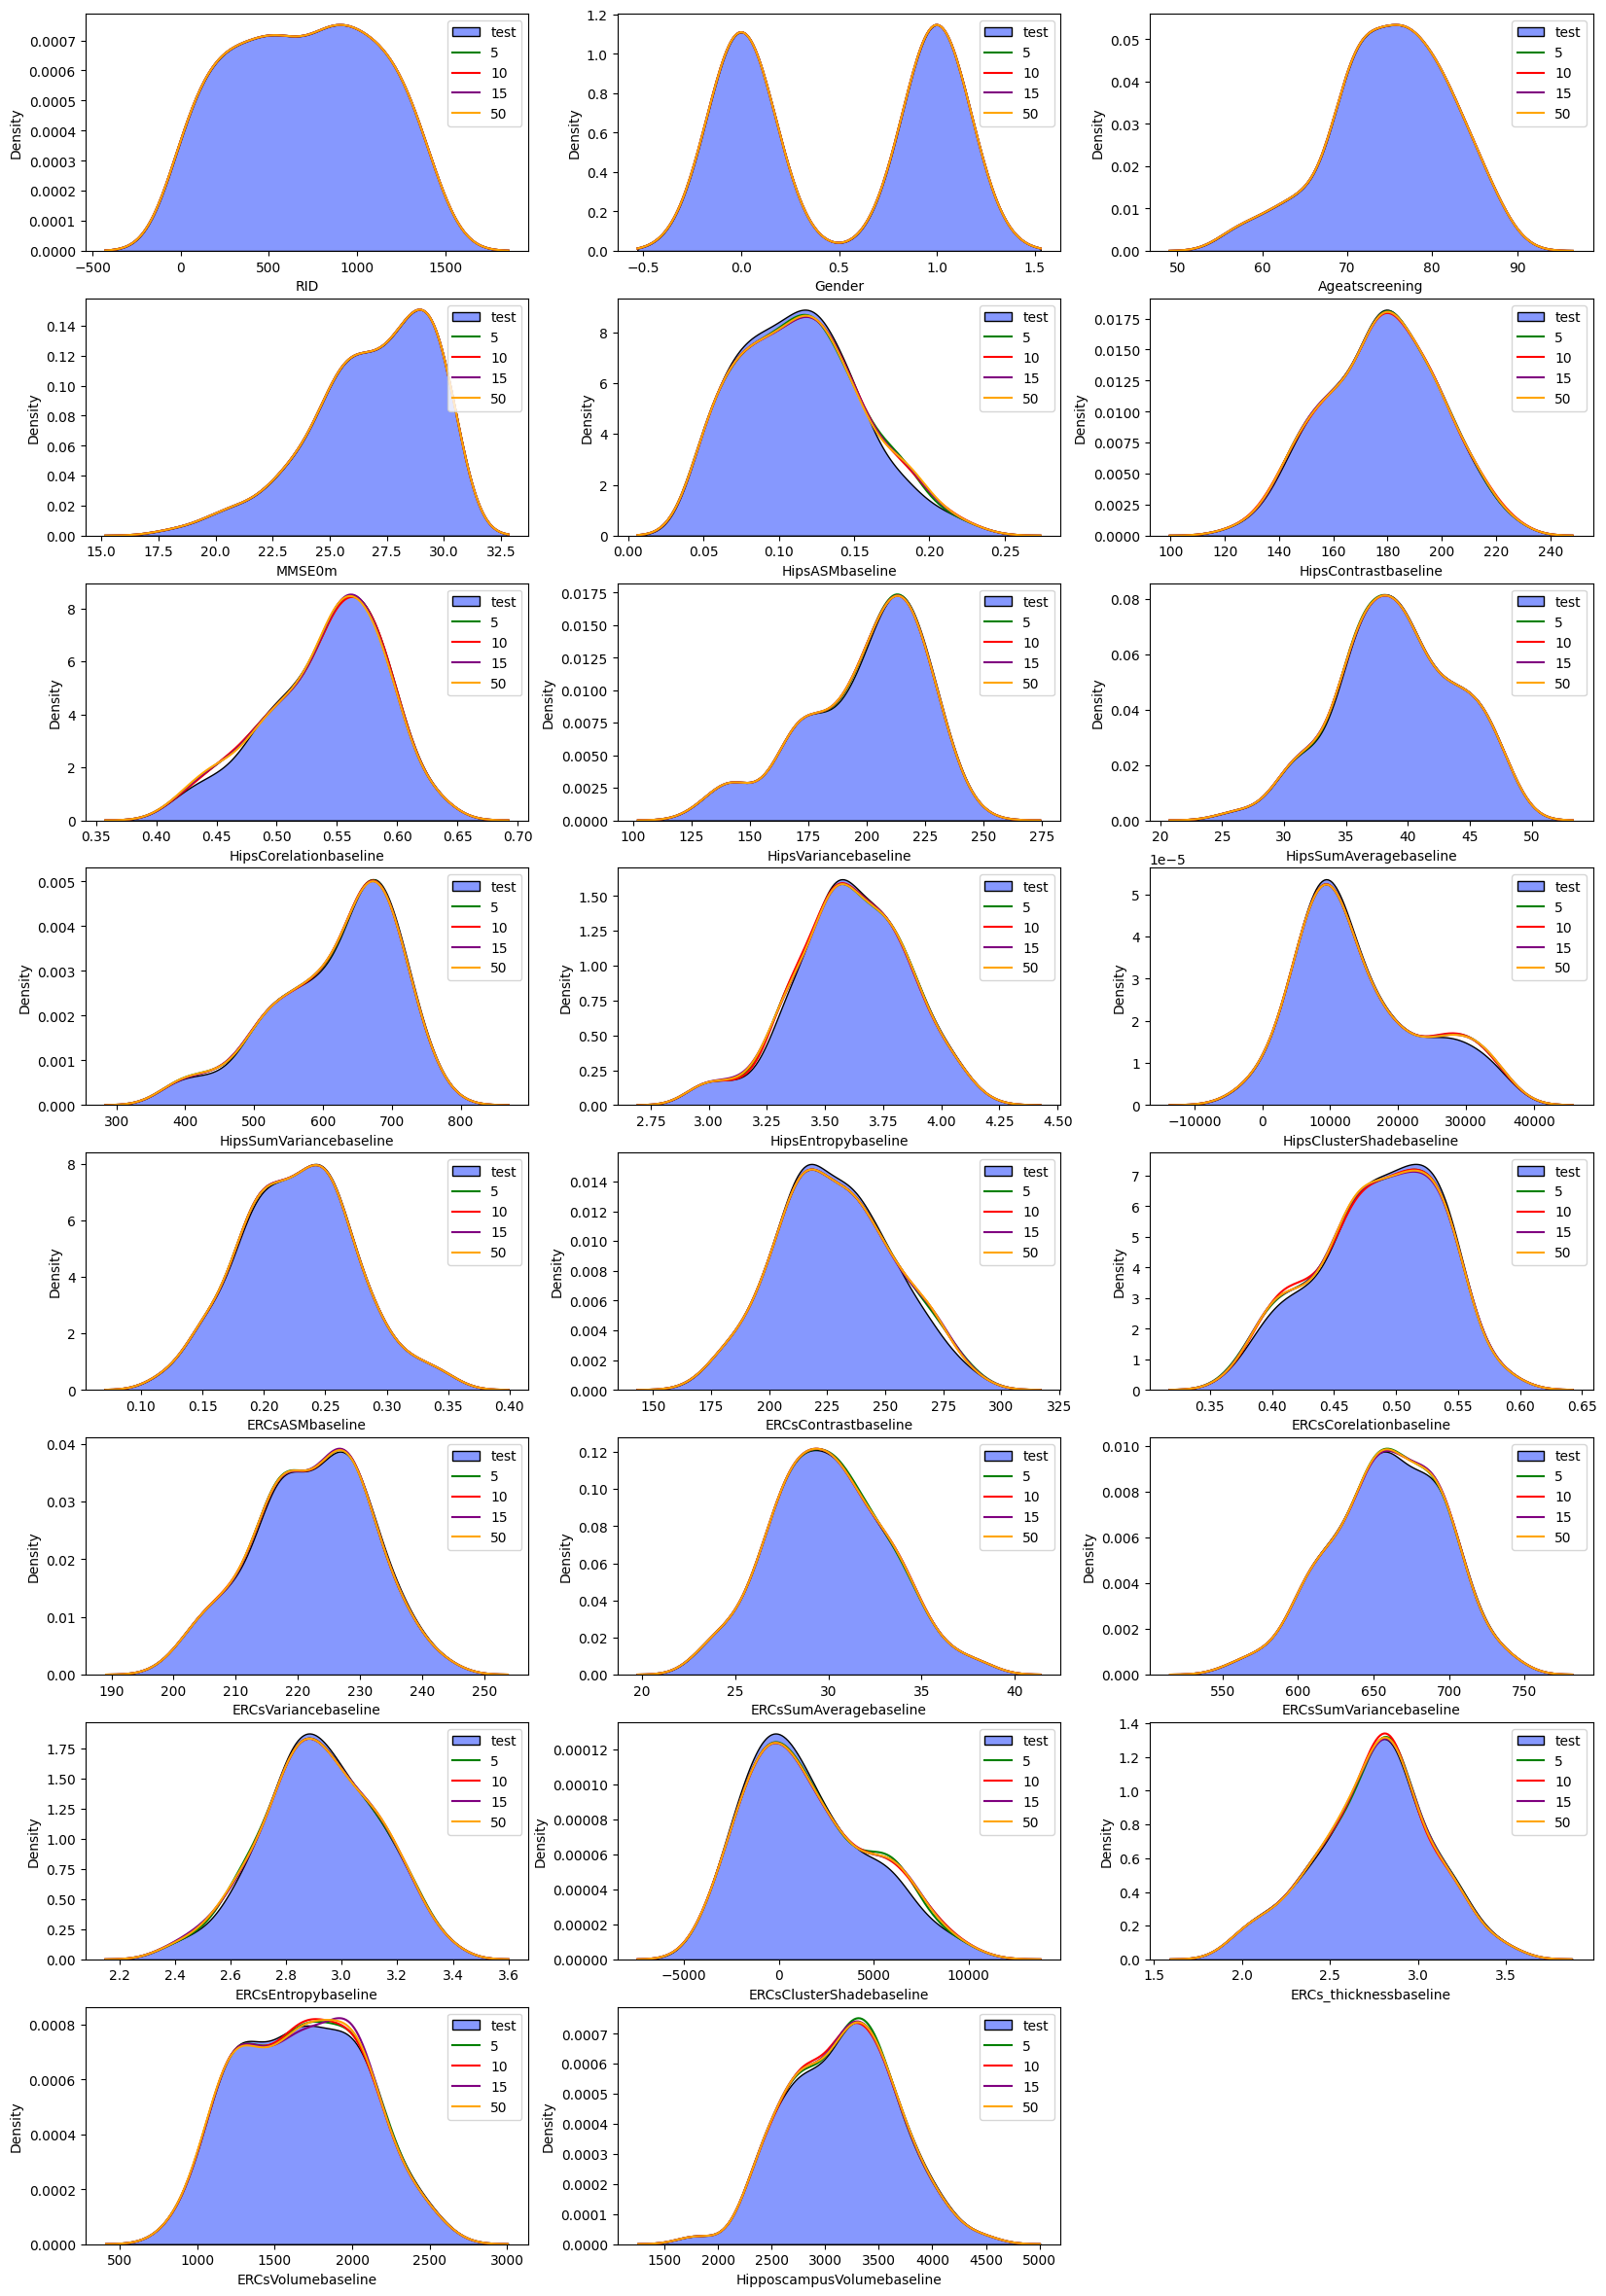

In [21]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_copy[X_test_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_imputed_5[X_test_imputed_5.columns[i]], color= "green")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_imputed_10[X_test_imputed_10.columns[i]], color= "red")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_imputed_15[X_test_imputed_15.columns[i]], color= "purple")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_imputed_50[X_test_imputed_50.columns[i]], color= "orange")
    
    labels = ['test', '5', '10', '15', '50']
    plt.legend(labels, loc='upper right')

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

def run_random_forest(X_train, X_test, y_train, y_test):

        # Initialize the Random Forest with class weight balancing
        rf = RandomForestClassifier(n_estimators=100,
                                    max_depth=5,
                                    random_state=42,
                                    class_weight="balanced",
        )
        
        kf = StratifiedKFold(n_splits=5,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(rf,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring=["accuracy", "roc_auc_ovr_weighted"],
                                           return_train_score=True,
        )
        
        # Print mean and std of each metric (for train and test)
        print("Stratified Cross Validation Results")
        print(f'Mean train accuracy:', np.mean(cross_val_results['train_accuracy']), '±', np.std(cross_val_results['train_accuracy']))
        print(f'Mean train ROC-AUC:', np.mean(cross_val_results['train_roc_auc_ovr_weighted']), '±', np.std(cross_val_results['train_roc_auc_ovr_weighted']))
        print(f'Mean test accuracy:', np.mean(cross_val_results['test_accuracy']), '±', np.std(cross_val_results['test_accuracy']))
        print(f'Mean test ROC-AUC:', np.mean(cross_val_results['test_roc_auc_ovr_weighted']), '±', np.std(cross_val_results['test_roc_auc_ovr_weighted']))
        
        # Fit the model
        rf.fit(X_train, y_train)
        
        # Get predicted probabilities for ROC AUC
        pred_train_proba = rf.predict_proba(X_train)
        pred_test_proba = rf.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train_norm = rf.predict(X_train)
        pred_test_norm = rf.predict(X_test)
        
        # Calculate ROC-AUC
        roc_score_train = roc_auc_score(y_train, 
                                        pred_train_proba, 
                                        average="weighted", 
                                        multi_class="ovr",
        )
        roc_score_test = roc_auc_score(y_test,
                                    pred_test_proba,  
                                    average="weighted", 
                                    multi_class="ovr",
        )
        
        # Calculate accuracies
        accuracy_train = accuracy_score(y_train, pred_train_norm)
        accuracy_test = accuracy_score(y_test, pred_test_norm)
        
        # Print results
        print("\nFinal Predictions")
        print(f"Train Accuracy: {accuracy_train}")
        print(f"Train ROC-AUC: {roc_score_train}")
        print(f"Test Accuracy: {accuracy_test}")
        print(f"Test ROC-AUC: {roc_score_test}")

In [28]:
dataframes = [
    (X_train_imputed_5, X_test_imputed_5), 
    (X_train_imputed_10, X_test_imputed_10),
    (X_train_imputed_15, X_test_imputed_15),
    (X_train_imputed_50, X_test_imputed_50),
]

imputer_methods = ["5", "10", "15", "50"]
validations = []

for i, ((x_train, x_test), imputer_method) in enumerate(zip(dataframes, imputer_methods)):
    print(f"\nRunning random forest for dataset pair {i} with method {imputer_method}: ")
    results = run_random_forest(x_train, x_test, y_train, y_test)
    validations.append(results)


Running random forest for dataset pair 0 with method 5: 
Stratified Cross Validation Results
Mean train accuracy: 0.9011764705882352 ± 0.007803823036130361
Mean train ROC-AUC: 0.9858420512821132 ± 0.0010456723574565126
Mean test accuracy: 0.6376470588235293 ± 0.023995385946318986
Mean test ROC-AUC: 0.8192661862892485 ± 0.030073667872227258

Final Predictions
Train Accuracy: 0.8776470588235294
Train ROC-AUC: 0.9796806353626999
Test Accuracy: 0.5409836065573771
Test ROC-AUC: 0.8044716049531265

Running random forest for dataset pair 1 with method 10: 
Stratified Cross Validation Results
Mean train accuracy: 0.9017647058823529 ± 0.01595842348970651
Mean train ROC-AUC: 0.9859325669524563 ± 0.0011717028697727503
Mean test accuracy: 0.6235294117647059 ± 0.02881752638568443
Mean test ROC-AUC: 0.8163516268712847 ± 0.03031600856453192

Final Predictions
Train Accuracy: 0.8823529411764706
Train ROC-AUC: 0.9800895018106255
Test Accuracy: 0.5355191256830601
Test ROC-AUC: 0.808452931846796

Runnin